In [1]:

import pandas as pd

In [2]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000].drop(['anomaly', 'changepoint'], axis=1)
test_data = data[20000:].drop(['anomaly', 'changepoint'], axis=1)

# Normalisation des données
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Dimension de l'espace latent
input_dim = train_data.shape[1]
latent_dim = 2

# Encodeur
input_data = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(input_data)
h = Dense(64, activation='relu')(h)
h = Dense(32, activation='relu')(h)
h = Dense(16, activation='relu')(h)
h = Dense(8, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Echantillonnage de l'espace latent
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Décodeur
decoder_h = Dense(8, activation='relu')
decoder_h1 = Dense(16, activation='relu')
decoder_h2 = Dense(32, activation='relu')
decoder_h3 = Dense(64, activation='relu')
decoder_h4 = Dense(128, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h_decoded = decoder_h(z)
h_decoded = decoder_h1(h_decoded)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
h_decoded = decoder_h4(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

# Construction du VAE
vae = Model(input_data, x_decoded_mean)

# Définition de la perte VAE = perte de reconstruction + KL divergence
reconstruction_loss = mse(input_data, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Early stopping (optionnel)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# TensorBoard callback pour la visualisation
tensorboard_callback = TensorBoard(log_dir='./logs')

# Entraînement du modèle
epochs = 300
batch_size = 100

history = vae.fit(train_data, train_data,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(test_data, test_data),
                  callbacks=[early_stopping, tensorboard_callback])

# Définir l'encodeur
encoder = Model(input_data, z_mean)

# Définir le décodeur
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h1(_h_decoded)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h3(_h_decoded)
_h_decoded = decoder_h4(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

import os
from tensorflow.keras.models import load_model

# Définir le répertoire de sauvegarde
save_dir = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Chemins complets pour sauvegarder les modèles
vae_path = os.path.join(save_dir, 'vae_model6.h5')
encoder_path = os.path.join(save_dir, 'encoder_model6.h5')
decoder_path = os.path.join(save_dir, 'decoder_model6.h5')

# Sauvegarder les modèles
vae.save(vae_path)
encoder.save(encoder_path)
decoder.save(decoder_path)

print(f"Les modèles ont été sauvegardés dans {save_dir}")


2024-08-14 17:07:29.693558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 17:07:29.817033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 17:07:29.818505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 17:07:32.346039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/300
200/200 [==============================] - 10s 19ms/step - loss: 5.3097 - val_loss: 4.6498
Epoch 2/300
200/200 [==============================] - 2s 12ms/step - loss: 3.3321 - val_loss: 3.7826
Epoch 3/300
200/200 [==============================] - 1s 7ms/step - loss: 3.1096 - val_loss: 3.6076
Epoch 4/300
200/200 [==============================] - 1s 6ms/step - loss: 3.0130 - val_loss: 3.4483
Epoch 5/300
200/200 [==============================] - 1s 7ms/step - loss: 2.9571 - val_loss: 3.4272
Epoch 6/300
200/200 [==============================] - 1s 6ms/step - loss: 2.9008 - val_loss: 3.3582
Epoch 7/300
200/200 [==============================] - 1s 7ms/step - loss: 2.8762 - val_loss: 3.2851
Epoch 8/300
200/200 [==============================] - 1s 6ms/step - loss: 2.8388 - val_loss: 3.2237
Epoch 9/300
200/200 [==============================] - 1s 7ms/step - loss: 2.8036 - val_loss: 3.1344
Epoch 10/300
200/200 [==============================] - 1s 6ms/step - loss: 2.7559 - val

/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
print(train_data)

[[ 2.0888855   0.560021   -2.0932453  ... -0.46692204 -0.9203283
   0.35731378]
 [ 0.9614677  -0.26722276 -1.2849996  ... -0.47546127 -0.9089332
   0.35731378]
 [ 0.05378249 -0.5589405  -1.9976685  ... -0.49558774 -1.9036337
   0.35731378]
 ...
 [ 0.27544847 -2.4519665   0.4282105  ... -1.6719702  -0.9381158
  -1.2028809 ]
 [ 0.78224695 -0.95434874  1.0250885  ... -1.6853918   0.6441216
  -1.2028809 ]
 [-0.54368824 -0.04703357  0.11325876 ... -1.6931167  -0.36067617
  -1.2028809 ]]


78/78 [==============================] - 0s 2ms/step


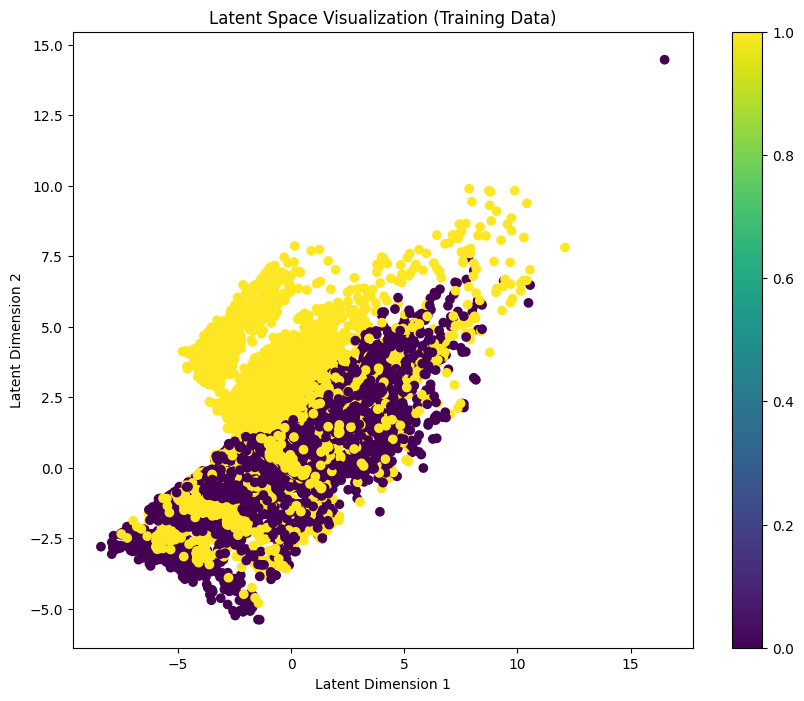

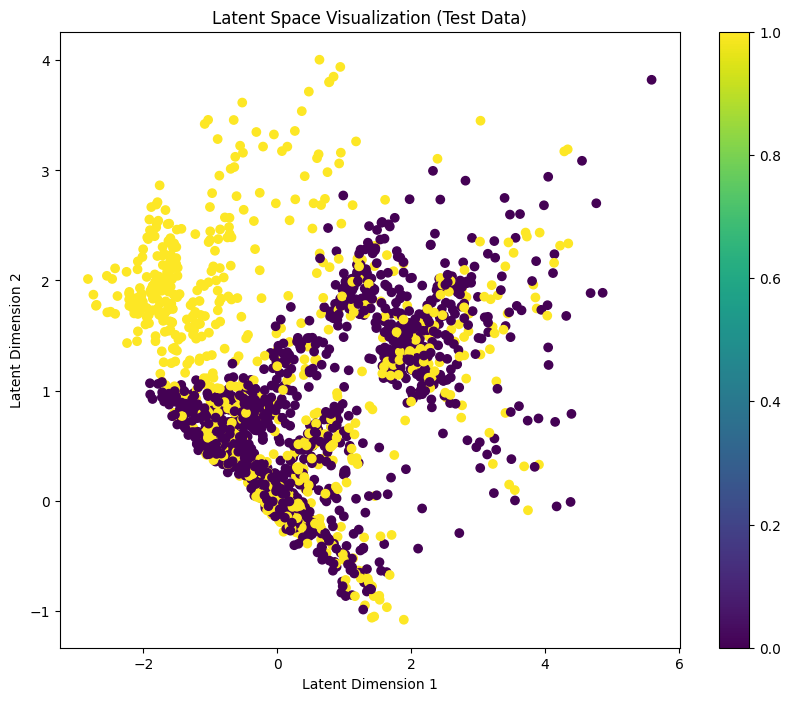

In [5]:
import matplotlib.pyplot as plt

# Encoder les données pour obtenir les vecteurs latents
encoder = Model(input_data, z_mean)
train_data_latent = encoder.predict(train_data)
test_data_latent = encoder.predict(test_data)

# Assumons que vous avez une colonne 'class' dans vos données d'origine pour les étiquettes de classe
train_labels = data[:20000]['anomaly']
test_labels = data[20000:]['anomaly']

# Visualisation des vecteurs latents en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Latent Space Visualization (Training Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_data_latent[:, 0], test_data_latent[:, 1], c=test_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Latent Space Visualization (Test Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


78/78 [==============================] - 0s 4ms/step
Class Prototypes in Latent Space:
Class 0.0: [-0.05277984  0.53648126]
Class 1.0: [-0.52019054  1.3887608 ]


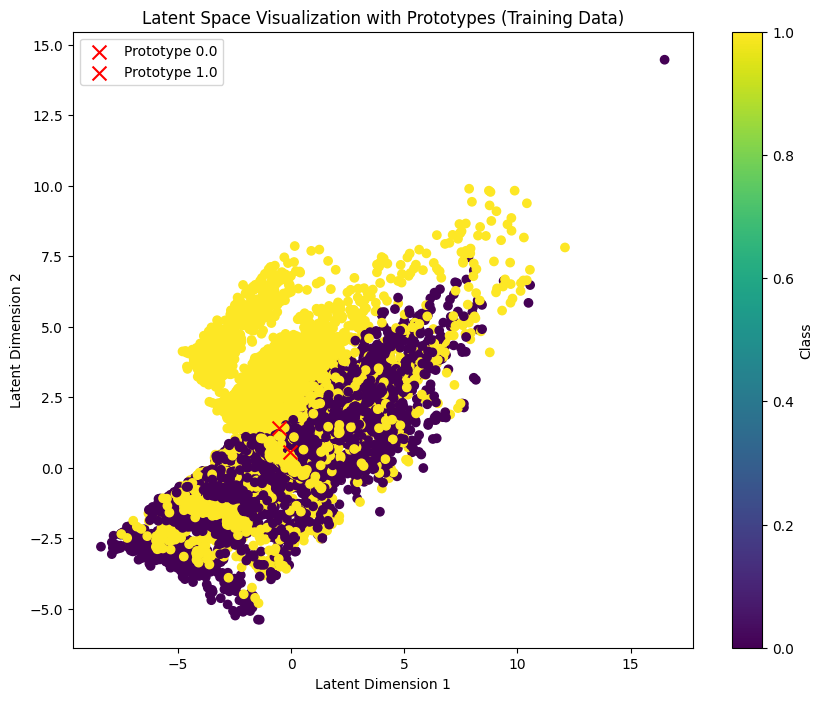

IndexError: index 2 is out of bounds for axis 1 with size 2

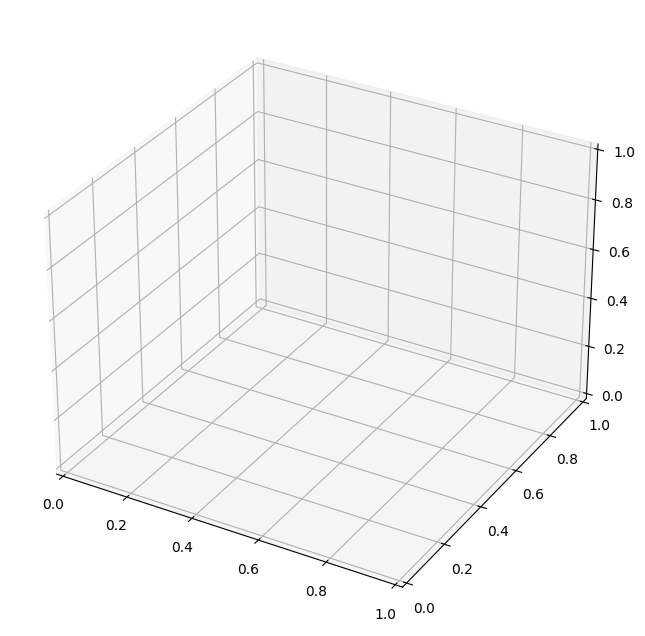

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model6.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model6.h5', compile=False)

# Encoder les données pour obtenir les vecteurs latents
train_data_latent = encoder.predict(train_data)
test_data_latent = encoder.predict(test_data)

# Assumons que vous avez une colonne 'class' dans vos données d'origine pour les étiquettes de classe
train_labels = data[:20000]['anomaly']
test_labels = data[20000:]['anomaly']

# Calculer les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
unique_classes = np.unique(train_labels)

for cls in unique_classes:
    class_latent_points = train_data_latent[train_labels == cls]
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)

# Afficher les prototypes
print("Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Visualisation des prototypes en 2D (utiliser les deux premières dimensions latentes)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_labels, cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Prototypes (Training Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

# Visualisation des prototypes en 3D (utiliser les trois premières dimensions latentes)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_data_latent[:, 0], train_data_latent[:, 1], train_data_latent[:, 2], c=train_labels, cmap='viridis')
fig.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    ax.scatter(prototype[0], prototype[1], prototype[2], c='red', marker='x', s=100, label=f'Prototype {cls}')
ax.set_title('Latent Space Visualization with Prototypes (Training Data)')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.legend()
plt.show()


In [ ]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)


# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-03-01 15:57:02           0.080787           0.131610  1.527880 -0.273216   
2020-03-01 15:57:03           0.081003           0.128565  1.785830 -0.273216   
2020-03-01 15:57:04           0.079904           0.133247  1.510950 -0.273216   
2020-03-01 15:57:05           0.080195           0.130859  1.637560  0.054711   
2020-03-01 15:57:06         

In [ ]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)


[[ 0.0764165   0.04553154  1.1337632  ...  1.03564867  0.97770943
   0.63632104]
 [ 0.07761434  0.03357089  0.82737483 ...  1.03666349 -0.7997969
   0.66172285]
 [ 0.11564941  0.04557186  0.6363226  ...  1.03791026 -0.07341779
   0.64786061]
 ...
 [-1.05857097 -0.99062324 -1.16196805 ... -1.62862464  0.45401324
  -1.3545326 ]
 [-1.05652054 -1.00666932 -0.9495032  ... -1.63048031 -0.0650372
  -1.3545326 ]
 [-1.05212305 -1.02502017 -1.05680122 ... -1.62911755 -0.31864134
  -1.3545326 ]]


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from tensorflow.keras.losses import mse

reconstructions = vae.predict(X, verbose=0)
reconstruction_error = mse(reconstructions, X)
print(reconstruction_error)

tf.Tensor([0.22532256 0.21961244 0.24222808 ... 1.27099987 1.4918605  1.30090553], shape=(14929,), dtype=float64)


In [ ]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.225323,False
1,0.219612,False
2,0.242228,False
3,0.226683,False
4,0.532507,False


In [ ]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0356	Accuracy: 0.351		Precision: 0.676	Recall Score: 0.500
Threshold: 0.0914	Accuracy: 0.403		Precision: 0.628	Recall Score: 0.535
Threshold: 0.1208	Accuracy: 0.453		Precision: 0.635	Recall Score: 0.569
Threshold: 0.1581	Accuracy: 0.503		Precision: 0.644	Recall Score: 0.601
Threshold: 0.2021	Accuracy: 0.540		Precision: 0.641	Recall Score: 0.621
Threshold: 0.2476	Accuracy: 0.561		Precision: 0.624	Recall Score: 0.621
Threshold: 0.2925	Accuracy: 0.581		Precision: 0.616	Recall Score: 0.622
Threshold: 0.3416	Accuracy: 0.603		Precision: 0.614	Recall Score: 0.624
Threshold: 0.3964	Accuracy: 0.618		Precision: 0.609	Recall Score: 0.619
Threshold: 0.4727	Accuracy: 0.622		Precision: 0.596	Recall Score: 0.601
Threshold: 0.5565	Accuracy: 0.617		Precision: 0.575	Recall Score: 0.574
Threshold: 0.6591	Accuracy: 0.607		Precision: 0.548	Recall Score: 0.541
Threshold: 0.7750	Accuracy: 0.605		Precision: 0.525	Recall Score: 0.518
Threshold: 0.9638	Accuracy: 0.605		Precision: 0.491	Recall Score

In [ ]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.341629


In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.225323,False,False
1,0.219612,False,False
2,0.242228,False,False
3,0.226683,False,False
4,0.532507,False,True
...,...,...,...
14924,1.223824,True,True
14925,1.146626,True,True
14926,1.271000,True,True
14927,1.491860,True,True


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()
print(fp,fn,tn,tp)

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de faux positifs: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de faux negatifs: {missing_alarm_rate:.2f}')

F1-score: 0.55
1602 4323 5365 3639
Taux de faux positifs: 0.23
Taux de faux negatifs: 0.54


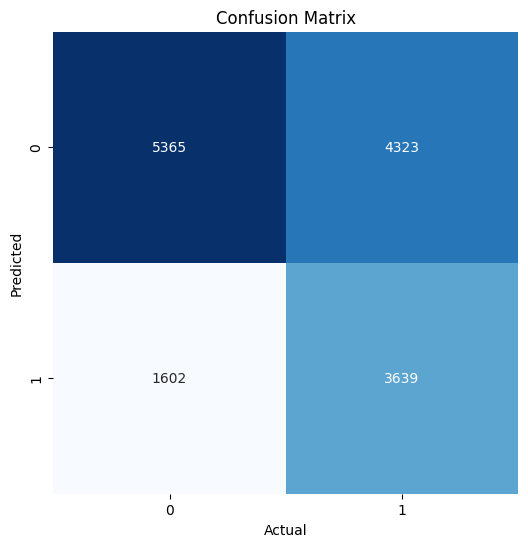

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

467/467 [==============================] - 1s 2ms/step
Threshold: 0.3436627252046685
Nombre d'anomalies détectées: 7912


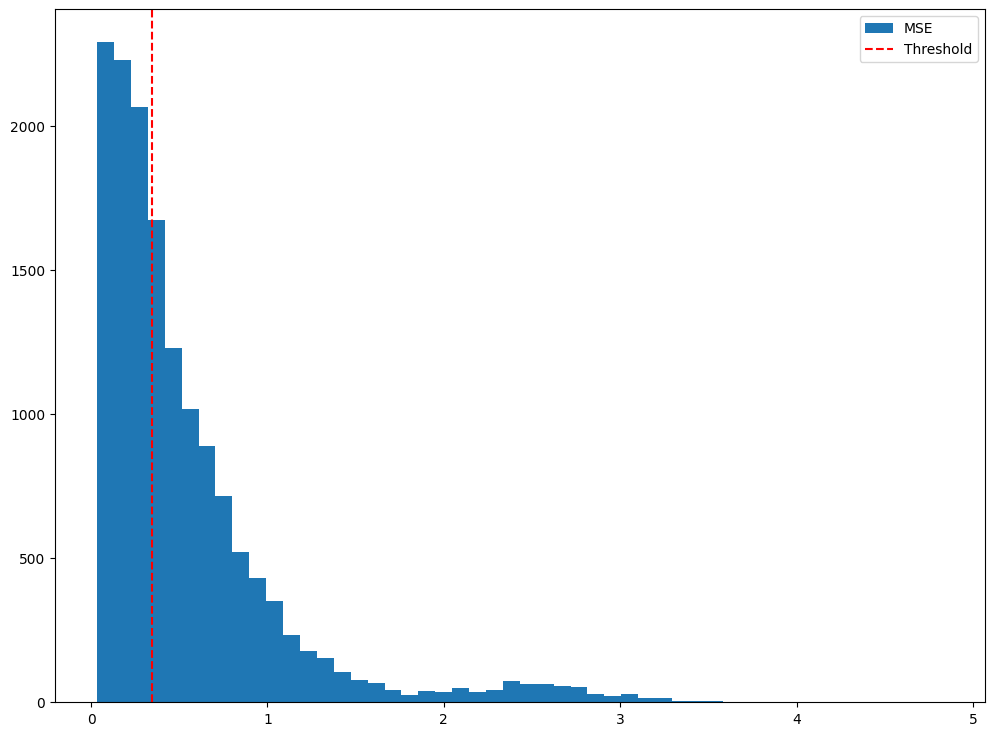

In [ ]:
# Prédire les données de test et calculer l'erreur de reconstruction
X_test_pred = vae.predict(X)
mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(mse, 47)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = mse > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

# Visualiser les anomalies détectées
plt.hist(mse, bins=50, label='MSE')
plt.axvline(threshold1, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [ ]:
recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.225323,False,False
1,0.219612,False,False
2,0.242228,False,False
3,0.226683,False,False
4,0.532507,False,True
...,...,...,...
14924,1.223824,True,True
14925,1.146626,True,True
14926,1.271000,True,True
14927,1.491860,True,True


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.55
Taux de fausses alarmes: 0.23
Taux de manque d'alarmes: 0.54


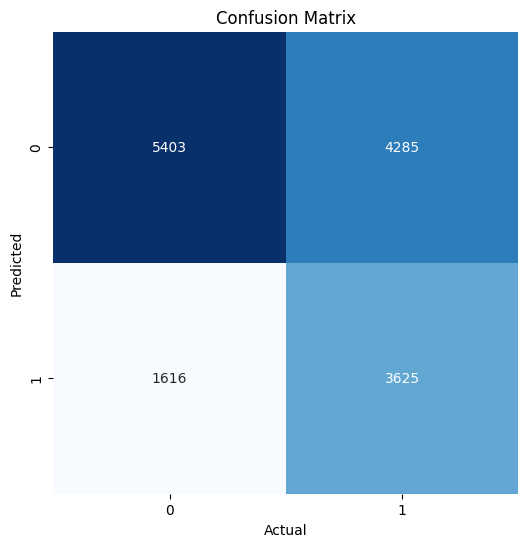

In [ ]:
cm = confusion_matrix(recons_df1['y_true'],recons_df1['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pip install statsmodels==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

# Calculer les p-valeurs
def calculate_p_values(errors, reference_errors):
    ecdf = ECDF(reference_errors)
    p_values = 1 - ecdf(errors)
    return p_values

# Appliquer la correction de Benjamini-Hochberg
def apply_bh_correction(p_values, alpha=0.05):
    m = len(p_values)
    sorted_p_values = np.sort(p_values)
    sorted_index = np.argsort(p_values)
    bh_thresholds = np.arange(1, m + 1) / m * alpha
    below_threshold = sorted_p_values <= bh_thresholds
    if not np.any(below_threshold):
        return None
    max_below = np.max(np.where(below_threshold)[0])
    threshold_p_value = sorted_p_values[max_below]
    return threshold_p_value

# Séparer les erreurs de reconstruction des données normales (y_true=0)
normal_errors = recons_df[recons_df['y_true'] == 0]['error'].values

# Calculer les p-valeurs pour toutes les données
recons_df['p_value'] = calculate_p_values(recons_df['error'].values, normal_errors)

# Appliquer la correction de Benjamini-Hochberg pour déterminer le seuil de p-valeur
alpha = 0.05
threshold_p_value = apply_bh_correction(recons_df['p_value'].values, alpha)

if threshold_p_value is not None:
    # Trouver le score d'anomalie correspondant au seuil de p-valeur
    threshold_score = np.percentile(recons_df['error'].values, (1 - threshold_p_value) * 100)
    print(f"Le seuil de score d'anomalie déterminé par FDR est : {threshold_score}")

    # Ajouter une colonne pour indiquer les anomalies détectées
    recons_df['is_anomaly'] = recons_df['error'] >= threshold_score
else:
    print("Aucun seuil trouvé avec le niveau de FDR spécifié.")

# Afficher le DataFrame avec les anomalies détectées
print(recons_df)


Le seuil de score d'anomalie déterminé par FDR est : 4.828051363475295
          error  y_true  y_pred   p_value  is_anomaly
0      0.225323   False   False  0.614575       False
1      0.219612   False   False  0.622729       False
2      0.242228   False   False  0.589905       False
3      0.226683   False   False  0.612201       False
4      0.532507   False    True  0.291701       False
...         ...     ...     ...       ...         ...
14924  1.223824    True    True  0.090731       False
14925  1.146626    True    True  0.100227       False
14926  1.271000    True    True  0.085983       False
14927  1.491860    True    True  0.070912       False
14928  1.300906    True    True  0.082989       False

[14929 rows x 5 columns]


Le seuil de score d'anomalie déterminé par FDR est : 4.828051363475295


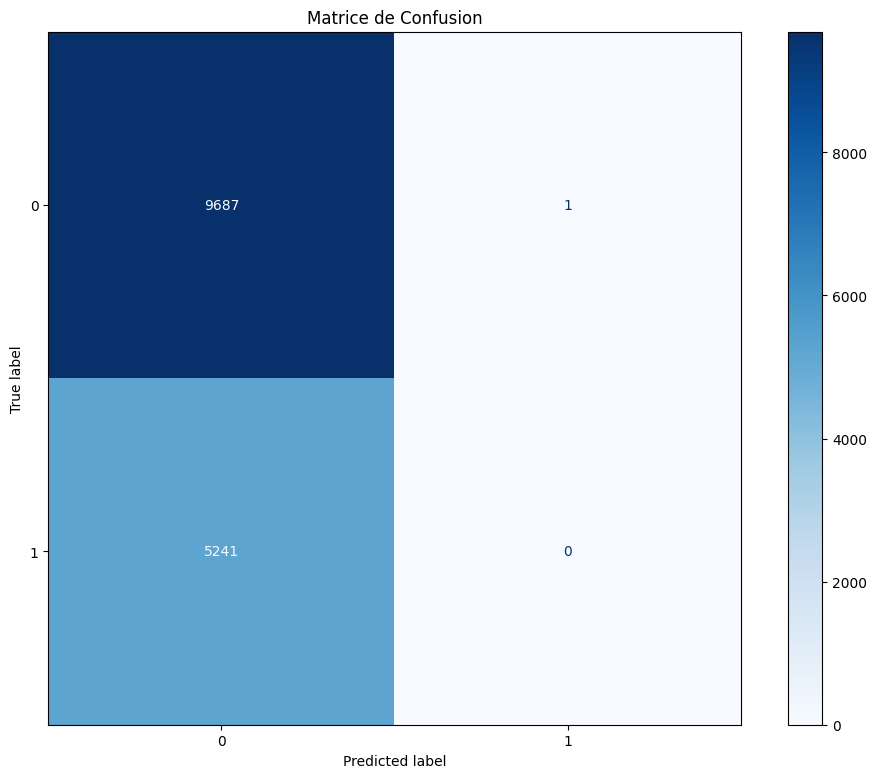

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Exemple de DataFrame recons_df avec des erreurs de reconstruction et des étiquettes vraies
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y
# }).reset_index(drop=True)

# Supposons que recons_df est déjà défini comme suit :
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y
# }).reset_index(drop=True)

# Calculer les p-valeurs
def calculate_p_values(errors, reference_errors):
    ecdf = ECDF(reference_errors)
    p_values = 1 - ecdf(errors)
    return p_values

# Appliquer la correction de Benjamini-Hochberg (BH)
def apply_bh_correction(p_values, alpha=0.05):
    m = len(p_values)
    sorted_p_values = np.sort(p_values)
    sorted_index = np.argsort(p_values)
    bh_thresholds = np.arange(1, m+1) / m * alpha
    below_threshold = sorted_p_values <= bh_thresholds
    if not np.any(below_threshold):
        return None
    max_below = np.max(np.where(below_threshold)[0])
    threshold_p_value = sorted_p_values[max_below]
    return threshold_p_value

# Séparer les erreurs de reconstruction en fonction de y_true
normal_errors = recons_df[recons_df['y_true'] == 0]['error']
anomaly_errors = recons_df[recons_df['y_true'] == 1]['error']

# Utiliser les erreurs des données normales comme référence pour les p-valeurs
p_values = calculate_p_values(recons_df['error'], normal_errors)

# Appliquer la correction BH pour déterminer le seuil
threshold_p_value = apply_bh_correction(p_values, alpha=0.15)

if threshold_p_value is not None:
    # Trouver le score d'anomalie correspondant au seuil de p-valeur
    threshold_score = np.percentile(recons_df['error'], (1 - threshold_p_value) * 100)
    print(f"Le seuil de score d'anomalie déterminé par FDR est : {threshold_score}")

    # Prédire les anomalies en utilisant le seuil
    recons_df['y_pred'] = (recons_df['error'] >= threshold_score).astype(int)

    # Calculer la matrice de confusion
    cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Tracer la matrice de confusion
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.show()
else:
    print("Aucun seuil trouvé avec le niveau de FDR spécifié.")


In [ ]:
recons_df2 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df2.head()

,error,y_true
0,0.225323,False
1,0.219612,False
2,0.242228,False
3,0.226683,False
4,0.532507,False


In [ ]:
recons_df1['y_pred'] = recons_df1['error'] > threshold
recons_df1

In [ ]:
import tensorflow as tf
import numpy as np

# Supposons que nous avons déjà un modèle autoencoder entraîné
# appelé 'autoencoder' et des données de test 'X_test'

def detect_anomalies(X_test_pred, X_test, k=3):
    # Calculer les erreurs de reconstruction
    #reconstructions = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
    
    # Calculer la moyenne et l'écart-type des erreurs
    mean = tf.reduce_mean(mse)
    std = tf.math.reduce_std(mse)
    
    # Définir le seuil
    threshold = mean + k * std
    
    # Détecter les anomalies
    anomalies = mse > threshold
    
    return anomalies, threshold

# Utilisation de la fonction
anomalies, threshold = detect_anomalies(X_test_pred, X, k=3)

# Afficher les résultats
print(f"Seuil de détection: {threshold:.4f}")
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")
print(f"Pourcentage d'anomalies: {100 * np.mean(anomalies):.2f}%")

# Optionnel : Afficher les indices des anomalies
anomaly_indices = np.where(anomalies)[0]
print("Indices des anomalies:", anomaly_indices)

Seuil de détection: 2.1650
Nombre d'anomalies détectées: 504
Pourcentage d'anomalies: 3.38%
Indices des anomalies: [  580   797  1186  2588  2602  2663  2854  2855  2859  5149  6533  6638
  7370  7371  8998  9981 10243 10327 10446 10497 10503 10725 10899 10924
 11731 12499 12757 13140 13165 13455 13494 13555 13777 14007 14014 14069
 14131 14133 14185 14186 14190 14192 14203 14205 14207 14208 14210 14211
 14212 14213 14214 14215 14218 14220 14221 14225 14226 14228 14229 14230
 14231 14232 14233 14234 14235 14236 14237 14238 14239 14240 14241 14242
 14245 14246 14247 14248 14249 14250 14251 14253 14254 14255 14256 14257
 14258 14259 14260 14261 14262 14263 14264 14265 14266 14267 14268 14269
 14270 14271 14272 14273 14274 14275 14276 14277 14278 14279 14280 14281
 14282 14283 14284 14285 14286 14287 14288 14289 14290 14291 14292 14293
 14294 14295 14296 14297 14298 14299 14300 14301 14302 14303 14304 14305
 14306 14307 14308 14309 14310 14311 14312 14313 14314 14315 14316 14317
 14318 14

In [ ]:
print(threshold)

tf.Tensor(2.1649988438943604, shape=(), dtype=float64)


In [ ]:
recons_df2 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df2.head()

,error,y_true
0,0.225323,False
1,0.219612,False
2,0.242228,False
3,0.226683,False
4,0.532507,False


In [ ]:
# Conversion de la colonne 'error' en float64
recons_df2['error'] = recons_df2['error'].astype('float64')

# Conversion du seuil en float64
threshold = float(threshold)

In [ ]:
recons_df2['y_pred'] = recons_df2['error'] > threshold
recons_df2

,error,y_true,y_pred
0,0.225323,False,False
1,0.219612,False,False
2,0.242228,False,False
3,0.226683,False,False
4,0.532507,False,False
...,...,...,...
14924,1.223824,True,False
14925,1.146626,True,False
14926,1.271000,True,False
14927,1.491860,True,False


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df2['y_true'], recons_df2['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df2['y_true'], recons_df2['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.01
Taux de fausses alarmes: 0.36
Taux de manque d'alarmes: 0.97


In [ ]:
testt = X[3020:3070, :]
print(testt)
y_testt = y[3050:3080]
print(y)
print(z[3050:3080])

[[-1.05098368e+00 -1.01934223e+00 -2.88950817e-01 -1.16696838e-01
   3.47589771e-01 -1.65692356e+00  5.90106838e-01 -1.24464485e+00]
 [-1.05400437e+00 -9.79959448e-01 -1.12431138e+00  2.39182327e+00
   2.09921483e-01 -1.65889520e+00  6.68265011e-01 -1.28079728e+00]
 [-1.05249226e+00 -9.79509244e-01 -7.37256509e-01 -1.37095689e+00
   3.66103411e-01 -1.65851827e+00  2.29291655e+00 -1.28007099e+00]
 [-1.04848371e+00 -1.02249366e+00 -1.03708349e+00 -1.16696838e-01
   3.92205490e-01 -1.65935912e+00  8.95725335e-01 -1.24464485e+00]
 [-1.05513386e+00 -9.77795781e-01 -1.29188692e+00 -1.16696838e-01
   3.51895269e-01 -1.65854726e+00 -4.89897010e-01 -1.28007099e+00]
 [-1.05065322e+00 -1.01927503e+00 -2.61106355e+00 -1.16696838e-01
   3.34404184e-01 -1.65918515e+00 -1.03837062e+00 -1.24392962e+00]
 [-1.05079203e+00 -9.91120478e-01 -4.65453878e-01 -1.16696838e-01
   3.56254585e-01 -1.65918515e+00  5.63903613e-02 -1.24392962e+00]
 [-1.05178483e+00 -9.79025443e-01 -2.63327326e+00 -1.16696838e-01
   

Data shape: (20000, 10)
Train labels shape: (20000, 1)
2/2 [==============================] - 0s 4ms/step
Train data latent shape: (20000, 3)
Test data latent shape: (50, 3)
Initial Class Prototypes in Latent Space:
Class 0.0: [  5.4303374 -56.140224  -17.383364 ]
Class 1.0: [  5.4328704 -56.15444   -17.29317  ]
1/1 [==============================] - 0s 22ms/step
Normal data point far from prototype: [-1.5661423 -0.4162909  0.9905312]
1/1 [==============================] - 0s 23ms/step
Normal data point far from prototype: [-0.94119835 -0.01579171  0.89404774]
1/1 [==============================] - 0s 24ms/step
Normal data point far from prototype: [-1.5792137  -0.75954944  0.87575376]
1/1 [==============================] - 0s 46ms/step
Normal data point far from prototype: [-1.5252453  -0.268686    0.94301844]
1/1 [==============================] - 0s 40ms/step
Normal data point far from prototype: [-1.4488475   0.57386035  0.969073  ]
1/1 [==============================] - 0s 27ms/st

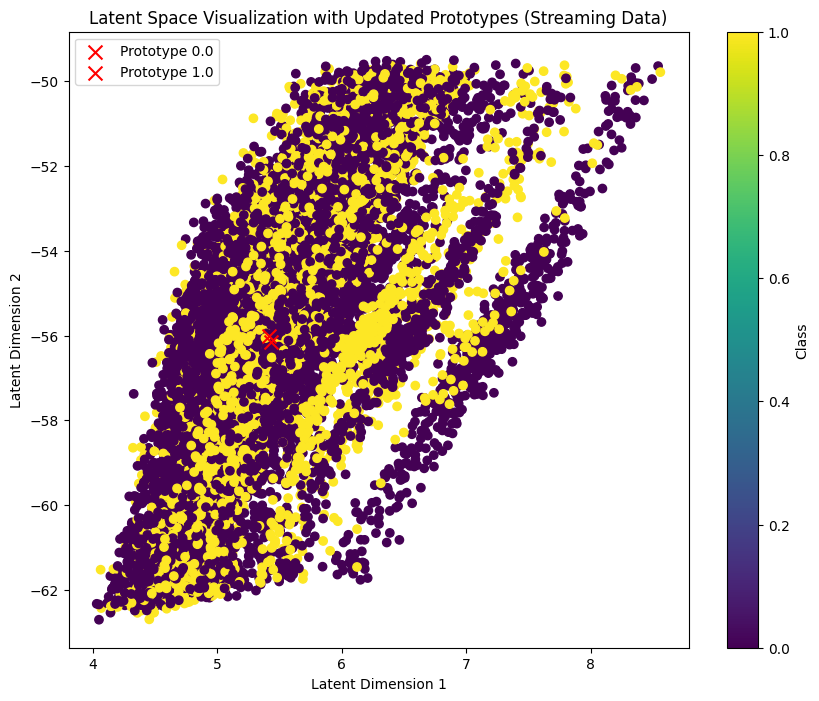

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model6.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model6.h5', compile=False)

# Supposons que vous avez déjà les données d'entraînement et de test
assert 'data' in globals(), "Les données d'entraînement 'data' ne sont pas définies"
assert 'testt' in globals(), "Les données de test 'testt' ne sont pas définies"
assert 'y_testt' in globals(), "Les étiquettes de test 'y_testt' ne sont pas définies"

# Assumons que vous avez une colonne 'anomaly' dans vos données d'origine pour les étiquettes de classe
train_data_labels = data[:20000][['anomaly']]
test_data_labels = y_testt

# Vérifiez les dimensions des données d'entraînement
print(f"Data shape: {data[:20000].shape}")
print(f"Train labels shape: {train_data_labels.shape}")

# Encoder les données initiales pour obtenir les vecteurs latents
train_data_latent = encoder.predict(data[:20000].drop(['anomaly', 'changepoint'], axis=1))
test_data_latent = encoder.predict(testt)

# Vérifiez les dimensions des données latentes
print(f"Train data latent shape: {train_data_latent.shape}")
print(f"Test data latent shape: {test_data_latent.shape}")

# Initialiser les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
class_counts = {}
unique_classes = np.unique(train_data_labels)

for cls in unique_classes:
    class_latent_points = train_data_latent[train_data_labels['anomaly'].values == cls].reshape(-1, train_data_latent.shape[-1])
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)
    class_counts[cls] = class_latent_points.shape[0]

# Afficher les prototypes initiaux
print("Initial Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Fonction pour mettre à jour les prototypes
def update_prototype(current_prototype, new_points, count):
    new_points_mean = np.mean(new_points, axis=0)
    new_count = new_points.shape[0]
    return (current_prototype * count + new_points_mean * new_count) / (count + new_count)

# Fonction pour détecter les anomalies
def detect_anomalies(latent_points, prototypes, threshold):
    distances = np.min(euclidean_distances(latent_points, np.vstack(list(prototypes.values()))), axis=1)
    return distances > threshold

# Initialiser les tampons pour chaque classe
buffers = defaultdict(list)
window_size = 10  # Taille de la fenêtre (nombre de points)
anomaly_threshold = threshold  # Exemple de seuil pour la détection d'anomalies
prototype_distance_threshold = 2.0  # Seuil pour la mise à jour des prototypes

# Fonction pour traiter les données de flux avec mise à jour après chaque fenêtre
def process_streaming_data(new_data_points, new_data_labels):
    latent_points = []
    labels = []
    for new_data_point, new_data_label in zip(new_data_points, new_data_labels):
        # Encoder le nouveau point de données
        new_data_latent = encoder.predict(np.array([new_data_point]))
        new_data_latent = new_data_latent.reshape(-1)  # Redimensionner pour correspondre

        # Calculer la distance par rapport aux prototypes
        distances = euclidean_distances([new_data_latent], np.vstack(list(class_prototypes.values())))
        closest_prototype_distance = np.min(distances)
        closest_prototype_class = list(class_prototypes.keys())[np.argmin(distances)]

        # Vérifier la distance par rapport au prototype
        if closest_prototype_distance > prototype_distance_threshold:
            if new_data_label == 0:  # Donnée normale
                print(f"Normal data point far from prototype: {new_data_latent}")
            elif new_data_label == 1:  # Donnée anormale
                print(f"Anomalous data point far from prototype: {new_data_latent}")

        # Ajouter le point latent au tampon correspondant à sa classe
        buffers[new_data_label].append(new_data_latent)
        latent_points.append(new_data_latent)
        labels.append(new_data_label)

        # Si le tampon atteint la taille de la fenêtre, mettre à jour le prototype
        if len(buffers[new_data_label]) >= window_size:
            class_prototypes[new_data_label] = update_prototype(
                class_prototypes[new_data_label],
                np.vstack(buffers[new_data_label]),  # Convertir la liste en tableau NumPy
                class_counts[new_data_label]
            )
            class_counts[new_data_label] += len(buffers[new_data_label])
            buffers[new_data_label] = []  # Réinitialiser le tampon

    # Convertir en tableau NumPy
    if latent_points:
        latent_points = np.array(latent_points)
        labels = np.array(labels)

        # Détecter les anomalies
        anomalies = detect_anomalies(latent_points, class_prototypes, anomaly_threshold)

        # Afficher les prototypes mis à jour et les anomalies détectées
        for cls, prototype in class_prototypes.items():
            print(f"Updated Class {cls} Prototype: {prototype}")
        print("Detected anomalies:", np.where(anomalies)[0])
    else:
        print("No data points processed in this window.")

# Exemple de traitement de nouvelles données en flux
for i in range(0, len(testt), window_size):
    new_data_points = testt[i:i+window_size]
    new_data_labels = y_testt[i:i+window_size]
    process_streaming_data(new_data_points, new_data_labels)

# Visualisation des prototypes mis à jour en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_data_labels['anomaly'], cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Updated Prototypes (Streaming Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


Data shape: (20000, 10)
Test data shape: (50, 8)
2/2 [==============================] - 0s 6ms/step
Initial Class Prototypes in Latent Space:
Class 0.0: [  5.4303374 -56.140224  -17.383364 ]
Class 1.0: [  5.4328704 -56.15444   -17.29317  ]
1/1 [==============================] - 0s 24ms/step
Updated Class 0.0 Prototype: [  5.4251604 -56.09721   -17.369469 ]
Updated Class 1.0 Prototype: [  5.4328704 -56.15444   -17.29317  ]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
Normal point at index 0 is far from the normal prototype.
Normal point at index 1 is far from the normal prototype.
Normal point at index 2 is far from the normal prototype.
Normal point at index 3 is far from the normal prototype.
Normal point at index 4 is far from the normal prototype.
Normal point at index 5 is far from the normal prototype.
Normal point at index 6 is far from the normal prototype.
Normal point at index 7 is far from the normal prototype.
Normal point at index 8 is far from the normal prototype.
Normal poi

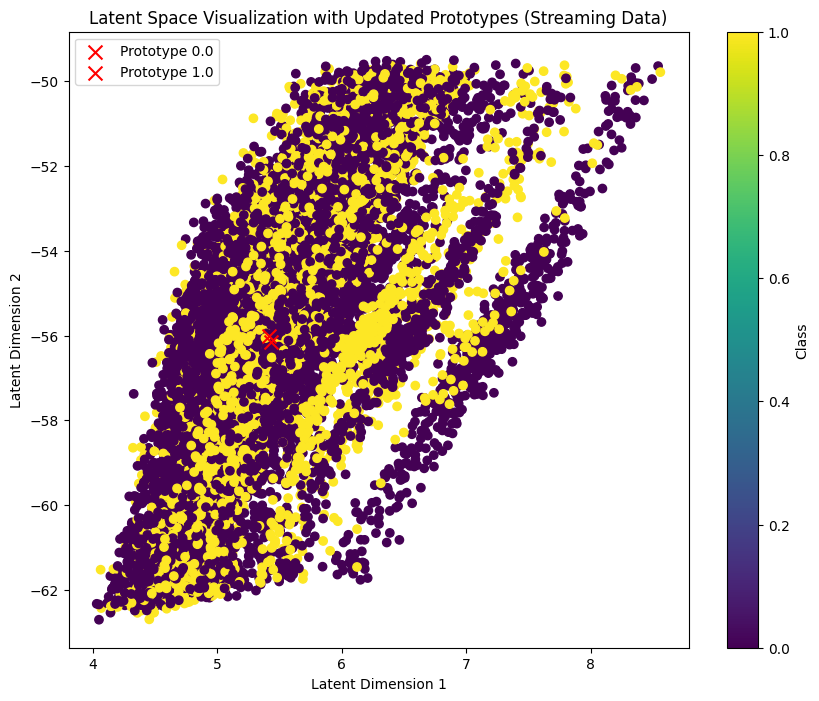

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model6.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model6.h5', compile=False)

# Assurez-vous que ces données existent
assert 'data' in globals(), "Les données d'entraînement 'data' ne sont pas définies"
assert 'testt' in globals(), "Les données de test 'testt' ne sont pas définies"
assert 'y_testt' in globals(), "Les étiquettes de test 'y_testt' ne sont pas définies"

# Assumons que vous avez une colonne 'anomaly' dans vos données d'origine pour les étiquettes de classe
train_data_labels = data[:20000][['anomaly']]
test_data_labels = y_testt

print(f"Data shape: {data[:20000].shape}")
print(f"Test data shape: {testt.shape}")

# Encoder les données initiales pour obtenir les vecteurs latents
train_data_latent = encoder.predict(data[:20000].drop(['anomaly', 'changepoint'], axis=1))
test_data_latent = encoder.predict(testt)

# Initialiser les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
class_counts = {}
unique_classes = np.unique(train_data_labels)

for cls in unique_classes:
    class_latent_points = train_data_latent[train_data_labels['anomaly'] == cls].reshape(-1, train_data_latent.shape[-1])
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)
    class_counts[cls] = class_latent_points.shape[0]

# Afficher les prototypes initiaux
print("Initial Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Fonction pour mettre à jour les prototypes
def update_prototype(current_prototype, new_points, count):
    new_points_mean = np.mean(new_points, axis=0)
    new_count = new_points.shape[0]
    return (current_prototype * count + new_points_mean * new_count) / (count + new_count)

# Fonction pour détecter les anomalies
def detect_anomalies(latent_points, prototypes, threshold):
    distances = euclidean_distances(latent_points, np.vstack(list(prototypes.values())))
    min_distances = np.min(distances, axis=1)
    return min_distances > threshold, min_distances

# Initialiser les tampons pour chaque classe
buffers = defaultdict(list)
window_size = 10  # Taille de la fenêtre (nombre de points)
anomaly_threshold = threshold  # Exemple de seuil pour la détection d'anomalies

# Fonction pour traiter les données de flux avec mise à jour après chaque fenêtre
def process_streaming_data(new_data_points, new_data_labels):
    latent_points = []
    labels = []
    for new_data_point, new_data_label in zip(new_data_points, new_data_labels):
        # Encoder le nouveau point de données
        new_data_latent = encoder.predict(np.array([new_data_point]))
        new_data_latent = new_data_latent.reshape(-1)  # Redimensionner pour correspondre

        # Ajouter le point latent au tampon correspondant à sa classe
        buffers[new_data_label].append(new_data_latent)
        latent_points.append(new_data_latent)
        labels.append(new_data_label)

        # Si le tampon atteint la taille de la fenêtre, mettre à jour le prototype
        if len(buffers[new_data_label]) >= window_size:
            class_prototypes[new_data_label] = update_prototype(
                class_prototypes[new_data_label],
                np.vstack(buffers[new_data_label]),  # Convertir la liste en tableau NumPy
                class_counts[new_data_label]
            )
            class_counts[new_data_label] += len(buffers[new_data_label])
            buffers[new_data_label] = []  # Réinitialiser le tampon

    # Convertir en tableau NumPy
    if latent_points:
        latent_points = np.array(latent_points)
        labels = np.array(labels)

        # Détecter les anomalies
        anomalies, distances = detect_anomalies(latent_points, class_prototypes, anomaly_threshold)

        # Afficher les prototypes mis à jour et les anomalies détectées
        for cls, prototype in class_prototypes.items():
            print(f"Updated Class {cls} Prototype: {prototype}")
        print("Detected anomalies:", np.where(anomalies)[0])

        # Identifier les points très éloignés des prototypes de leur classe
        for i, (latent_point, label, distance) in enumerate(zip(latent_points, labels, distances)):
            if anomalies[i]:
                if label == 1:  # Classe anormale
                    print(f"Anomalous point at index {i} is far from the anomaly prototype.")
                else:  # Classe normale
                    print(f"Normal point at index {i} is far from the normal prototype.")
    else:
        print("No data points processed in this window.")

# Exemple de traitement de nouvelles données en flux
for i in range(0, len(testt), window_size):
    new_data_points = testt[i:i+window_size]
    new_data_labels = y_testt[i:i+window_size]
    process_streaming_data(new_data_points, new_data_labels)

# Visualisation des prototypes mis à jour en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_data_labels['anomaly'], cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Updated Prototypes (Streaming Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()
